<a href="https://colab.research.google.com/github/coder-penguin/ML/blob/master/tutorial/scikit_learn_tutorial_hpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sample code for hyper parameter tuning

Load libraries

In [1]:
!pip install optuna

     |████████████████████████████████| 163kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 37.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 112kB 44.4MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=a225013f4608937615187dba5ee435e13f04b851c07443f54792d68ad136cee7
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.3.0-cp36-none-any.whl size=221121 sha256=280b7707f0c42fa96abf5fcc0ed98b07a155ce0f02b2b0e4078e833aac790e05
  Stored in directory: /root/.cache/pip/wheels/62

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from hyperopt import fmin, tpe, hp, rand, Trials
from hyperopt.pyll.base  import scope
import optuna

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Read data

In [0]:
# read the breast cancer wisconsin dataset
dataset = load_breast_cancer()

In [4]:
#30 features
dataset['data'].shape

(569, 30)

In [5]:
#binary target
dataset['target']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [6]:
dataset['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [7]:
dataset['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

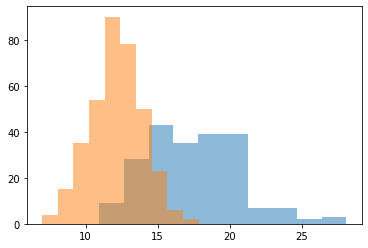

In [8]:
# show data
plt.hist(dataset['data'][:, 0][dataset['target']==0], label=dataset['target_names'][0], alpha=0.5)
plt.hist(dataset['data'][:, 0][dataset['target']==1], label=dataset['target_names'][1], alpha=0.5)
plt.show()

In [0]:
# image(numpy.ndarray)
X = dataset.data

# label(numpy.ndarray)
y = dataset.target

In [0]:
#split dataset to train and test dataset
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)#default is True

In [11]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

455 114
455 114


In [0]:
df = pd.DataFrame(data=X_train, columns=dataset.feature_names)

In [0]:
df['target'] = y_train

In [14]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,16.350,23.29,109.00,840.4,0.09742,0.14970,0.18110,0.08773,0.2175,0.06218,0.4312,1.022,2.972,45.50,0.005635,0.03917,0.06072,0.016560,0.03197,0.004085,19.38,31.03,129.30,1165.0,0.1415,0.4665,0.70870,0.22480,0.4824,0.09614,0
1,9.755,28.20,61.68,290.9,0.07984,0.04626,0.01541,0.01043,0.1621,0.05952,0.1781,1.687,1.243,11.28,0.006588,0.01270,0.01450,0.006104,0.01574,0.002268,10.67,36.92,68.03,349.9,0.1110,0.1109,0.07190,0.04866,0.2321,0.07211,1
2,8.734,16.84,55.27,234.3,0.10390,0.07428,0.00000,0.00000,0.1985,0.07098,0.5169,2.079,3.167,28.85,0.015820,0.01966,0.00000,0.000000,0.01865,0.006736,10.17,22.80,64.01,317.0,0.1460,0.1310,0.00000,0.00000,0.2445,0.08865,1
3,11.840,18.70,77.93,440.6,0.11090,0.15160,0.12180,0.05182,0.2301,0.07799,0.4825,1.030,3.475,41.00,0.005551,0.03414,0.04205,0.010440,0.02273,0.005667,16.82,28.12,119.40,888.7,0.1637,0.5775,0.69560,0.15460,0.4761,0.14020,0
4,10.490,19.29,67.41,336.1,0.09989,0.08578,0.02995,0.01201,0.2217,0.06481,0.3550,1.534,2.302,23.13,0.007595,0.02219,0.02880,0.008614,0.02710,0.003451,11.54,23.31,74.22,402.8,0.1219,0.1486,0.07987,0.03203,0.2826,0.07552,1


In [15]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.097059,19.393758,91.765077,650.079780,0.096107,0.104710,0.089057,0.048637,0.181254,0.062870,0.400126,1.219523,2.815558,39.256738,0.007023,0.025571,0.032252,0.011741,0.020386,0.003802,16.265505,25.778769,107.207429,878.997802,0.132099,0.257044,0.275443,0.114726,0.290479,0.084433,0.621978
std,3.422582,4.365526,23.596699,333.413717,0.014237,0.053923,0.080070,0.038569,0.028103,0.007279,0.250284,0.564869,1.767032,36.368459,0.003095,0.018067,0.031989,0.006169,0.008143,0.002639,4.771328,6.139128,33.122503,555.300110,0.022949,0.162097,0.214403,0.066054,0.062885,0.018851,0.485427
min,6.981000,10.380000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.870000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.695000,16.190000,74.935000,420.050000,0.085345,0.064120,0.028360,0.019685,0.161750,0.057885,0.227200,0.832400,1.574500,17.740000,0.005080,0.012805,0.014550,0.007759,0.015210,0.002238,12.980000,21.250000,83.795000,511.500000,0.116600,0.142650,0.108800,0.064985,0.250300,0.071270,0.000000
50%,13.380000,18.900000,86.340000,551.700000,0.095660,0.092180,0.061950,0.033500,0.179200,0.061400,0.324200,1.108000,2.302000,24.720000,0.006292,0.020750,0.026020,0.010830,0.018680,0.003187,14.970000,25.460000,97.960000,687.600000,0.131200,0.211700,0.229900,0.101500,0.282300,0.080240,1.000000
75%,15.940000,21.760000,104.900000,790.850000,0.104900,0.130550,0.131300,0.071905,0.195800,0.066005,0.474700,1.466500,3.306500,45.075000,0.008060,0.032460,0.042890,0.014685,0.023360,0.004504,18.895000,29.690000,126.500000,1091.500000,0.146000,0.343500,0.385700,0.162650,0.318150,0.092220,1.000000
max,27.220000,39.280000,182.100000,2250.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,1.509000,4.885000,10.120000,233.000000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,33.130000,49.540000,229.300000,3432.000000,0.218400,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfc0ea3470>,
      dtype=object)

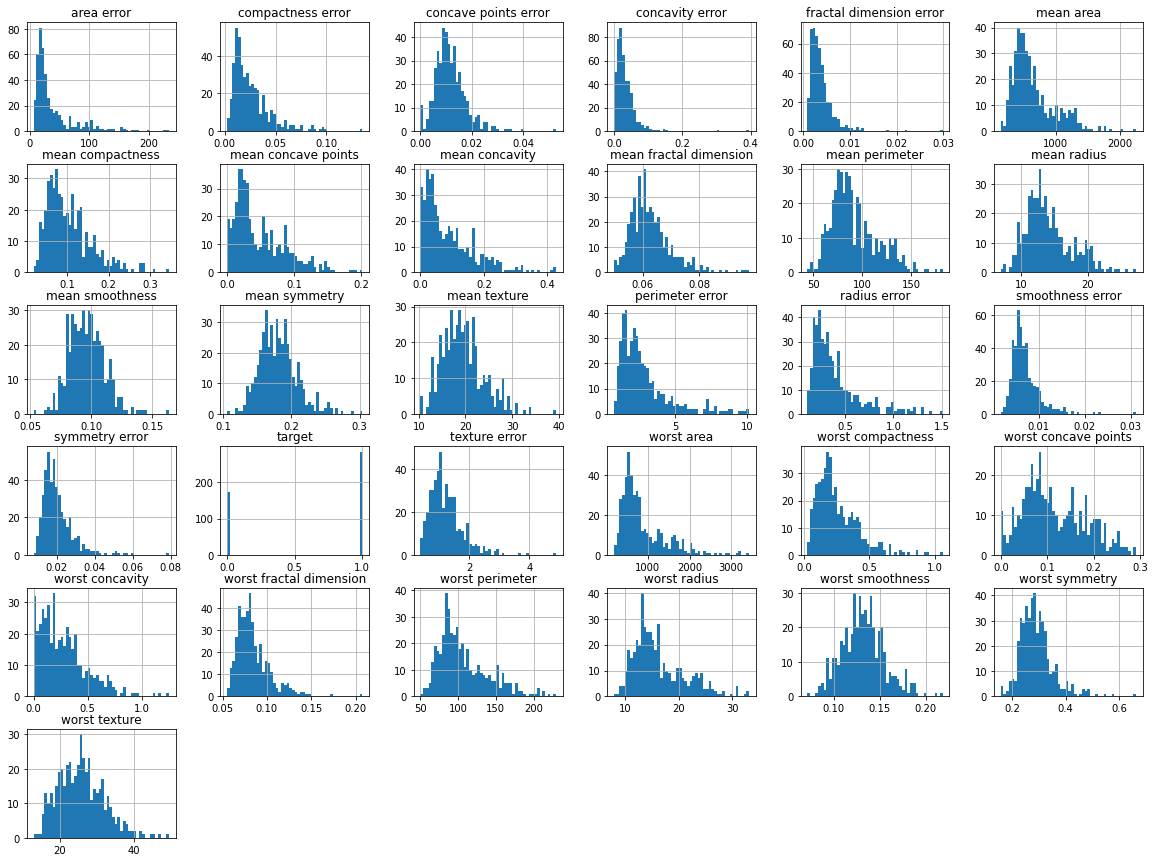

In [16]:
# show data
df.hist(bins=50, figsize=(20,15))

In [0]:
#standard correlation coefficient
corr_mx = df.corr()

In [18]:
corr_mx['target'].sort_values(ascending=False)

target                     1.000000
smoothness error           0.056944
texture error              0.041983
mean fractal dimension    -0.005972
symmetry error            -0.007385
fractal dimension error   -0.086545
concavity error           -0.242689
compactness error         -0.303833
worst fractal dimension   -0.335437
mean symmetry             -0.338206
mean texture              -0.376475
mean smoothness           -0.386158
concave points error      -0.410491
worst texture             -0.430234
worst symmetry            -0.433414
worst smoothness          -0.449876
worst compactness         -0.596458
mean compactness          -0.597512
perimeter error           -0.606032
radius error              -0.615297
area error                -0.650513
worst concavity           -0.655316
mean concavity            -0.693609
mean area                 -0.720389
mean radius               -0.732307
worst area                -0.741289
mean perimeter            -0.746621
worst radius              -0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfc076ee80>,
      dtype=object)

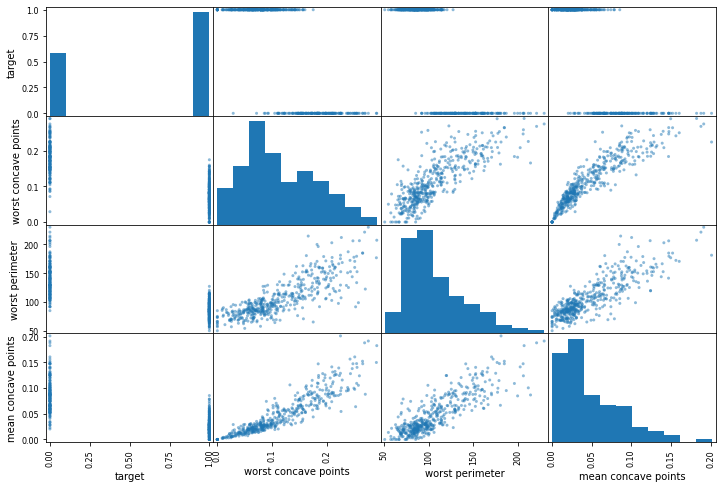

In [19]:
attributes = ['target', 'worst concave points', 'worst perimeter', 'mean concave points']
pd.plotting.scatter_matrix(df[attributes], figsize=(12, 8))

In [0]:
scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train)

###Hyper parameter tuning

GridSearchCV

In [0]:
param_grid = [{'n_estimators' : [10, 100, 500],
                       'max_depth' : [2, 4, 6, 8, 10]}]

In [0]:
model = RandomForestClassifier()

In [0]:
grid_search = GridSearchCV(model, param_grid, cv=3)

In [24]:
grid_search.fit(X_train_processed, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [25]:
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 10}

In [26]:
grid_search.best_score_

0.9625740676193796

RandomizedSearchCV

In [0]:
# specify parameters and distributions to sample from
param_dist = [{'n_estimators': range(10, 500),
                      'max_depth': range(1, 10)}]

n_iter_search = 100

In [0]:
model = RandomForestClassifier()

In [0]:
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter_search, cv=3)

In [30]:
random_search.fit(X_train_processed, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [31]:
random_search.best_params_

{'max_depth': 8, 'n_estimators': 113}

In [32]:
random_search.best_score_

0.9669745555942838

hyperopt

In [0]:
def objective_hyperopt(args):
        
    cv = 3
    model = RandomForestClassifier(**args)
    scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='accuracy')

    return 1 - scores.mean()

In [0]:
param_hyperopt = {'n_estimators': scope.int(hp.quniform('n_estimators',  10, 500, q=1)),
                               'max_depth': scope.int(hp.quniform('max_depth', 1, 10,  q=1))}

In [35]:
trials = Trials()
best = fmin(objective_hyperopt, param_hyperopt, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [02:03<00:00,  1.23s/it, best loss: 0.0330109213430928]


In [36]:
best

{'max_depth': 9.0, 'n_estimators': 46.0}

In [37]:
1 - trials.best_trial['result']['loss']

0.9669890786569072

optuna

In [0]:
def objective_optuna(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 1, 10)
        
    cv = 3
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='accuracy')
    
    return 1 - scores.mean()

In [0]:
study = optuna.create_study()

In [40]:
study.optimize(objective_optuna, n_trials=100)

[I 2020-04-03 03:01:12,697] Finished trial#0 with value: 0.039604391774137326 with parameters: {'n_estimators': 479, 'max_depth': 8}. Best is trial#0 with value: 0.039604391774137326.
[I 2020-04-03 03:01:14,702] Finished trial#1 with value: 0.04400487974904144 with parameters: {'n_estimators': 376, 'max_depth': 4}. Best is trial#0 with value: 0.039604391774137326.
[I 2020-04-03 03:01:16,098] Finished trial#2 with value: 0.03963343789938423 with parameters: {'n_estimators': 242, 'max_depth': 9}. Best is trial#0 with value: 0.039604391774137326.
[I 2020-04-03 03:01:16,795] Finished trial#3 with value: 0.04182642035552453 with parameters: {'n_estimators': 104, 'max_depth': 7}. Best is trial#0 with value: 0.039604391774137326.
[I 2020-04-03 03:01:18,512] Finished trial#4 with value: 0.04622690833042864 with parameters: {'n_estimators': 308, 'max_depth': 7}. Best is trial#0 with value: 0.039604391774137326.
[I 2020-04-03 03:01:20,278] Finished trial#5 with value: 0.041811897292901024 with p

In [41]:
study.best_params

{'max_depth': 9, 'n_estimators': 46}

In [42]:
1- study.best_value

0.9691820611130475

###Train model

In [0]:
model = RandomForestClassifier(n_estimators=study.best_params['n_estimators'], max_depth=study.best_params['max_depth'])

In [68]:
model.fit(X_train_processed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=46,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

###Evaluation

k-th cross validation

In [69]:
#k-th cross validation
cv = 3 #the number of foldings
cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='accuracy')

array([0.97368421, 0.96052632, 0.94039735])

confusion matrix

In [0]:
#calculate confusion matrix
y_train_pred = cross_val_predict(model, X_train_processed, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)

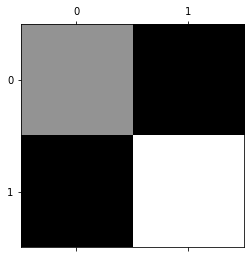

In [71]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

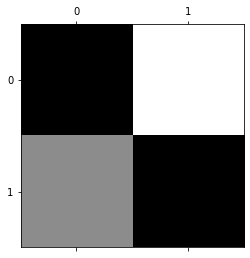

In [72]:
#convert to error probability
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#set diagonal to 0 for visibility
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

various scores

In [73]:
accuracy_score(y_train, y_train_pred)

0.9582417582417583

In [74]:
precision_score(y_train, y_train_pred)

0.9647887323943662

In [75]:
recall_score(y_train, y_train_pred)

0.9681978798586572

In [76]:
f1_score(y_train, y_train_pred)

0.9664902998236332

In [77]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       172
           1       0.96      0.97      0.97       283

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455



In [0]:
y_train_probas = cross_val_predict(model, X_train_processed, y_train, cv=cv, method='predict_proba')

In [0]:
y_train_scores = y_train_probas[:, 1]

In [0]:
def plot_pr_curve(y, y_score, label=None):

    fpr, tpr, thresholds = precision_recall_curve(y, y_score)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    return

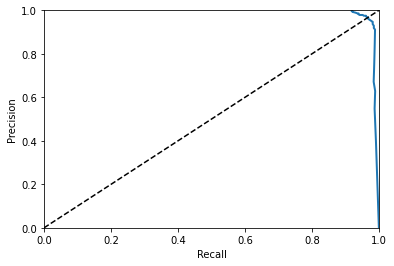

In [57]:
plot_pr_curve(y_train, y_train_scores)
plt.show()

In [0]:
def plot_roc_curve(y, y_score, label=None):

    fpr, tpr, thresholds = roc_curve(y, y_score)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    return

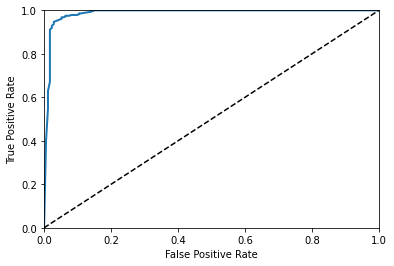

In [59]:
plot_roc_curve(y_train, y_train_scores)
plt.show()

In [60]:
roc_auc_score(y_train, y_train_scores)

0.9866361245788479

###Test

In [0]:
y_test_pred = model.predict(scaler.transform(X_test))

In [81]:
accuracy_score(y_test, y_test_pred)

0.956140350877193

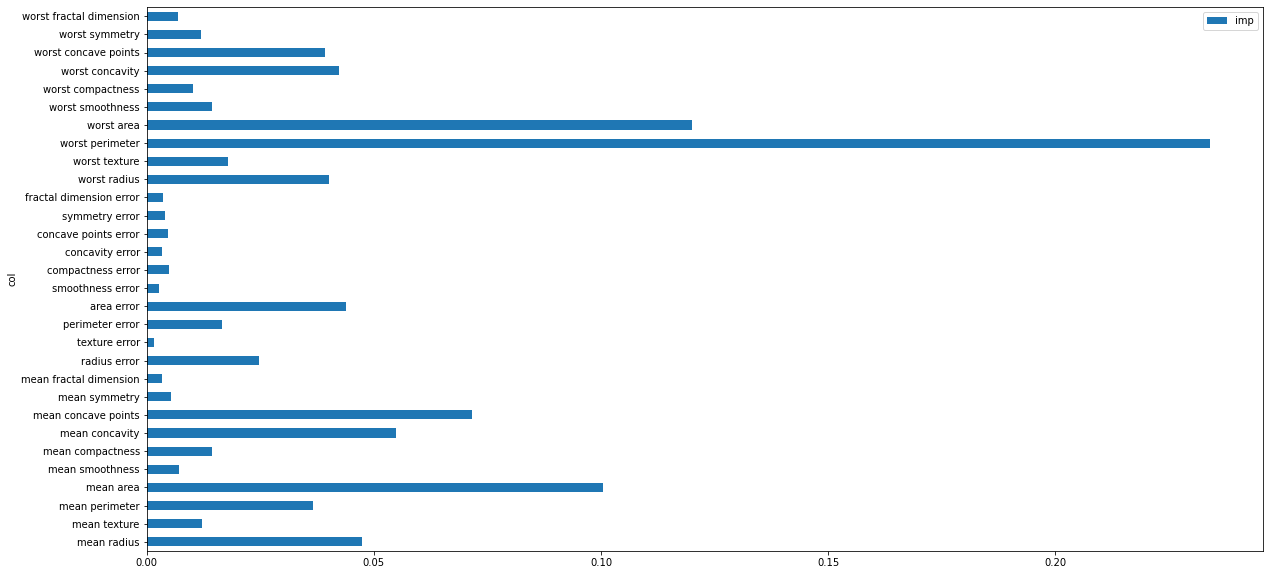

In [82]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': dataset['feature_names']})
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

###Save

In [0]:
#save the prediction
submissiondir = '.'
submissionname = 'submission'
pd.DataFrame(data={'target':y_test, 'prediction':y_test_pred}).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=["Id"])

In [84]:
# save the model
filename = 'model.sav'
joblib.dump(model, filename)

['model.sav']

In [85]:
# load the model
loaded_model = joblib.load(filename)
result = loaded_model.score(scaler.transform(X_test), y_test)
print(result)

0.956140350877193
